Rosenbrock Function:

\begin{equation}
\min_{x \in \mathbb{R}^n} \sum_{i=1}^{n-1} \left[ 100 (x_{i+1} - x_i^2)^2 + (x_i - 1)^2 \right].
\end{equation}

In [ ]:
# Load required packages
required_packages = ["DataFrames","LinearAlgebra","Statistics", "MAT","Random", "Plots","Zygote", "Measures", "PyPlot","CSV","Arpack","Downloads","SparseArrays"]
for pkg in required_packages
    try
        eval(Meta.parse("using $pkg"))
    catch e
        @warn "$pkg not found, installing..."
        import Pkg
        Pkg.add(pkg)
        eval(Meta.parse("using $pkg"))
    end
end

┌ Warning: MAT not found, installing...
└ @ Main In[1]:7
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed MicrosoftMPI_jll ── v10.1.4+3
   Installed MPICH_jll ───────── v4.3.1+0
   Installed MPIPreferences ──── v0.1.11
   Installed Hwloc_jll ───────── v2.12.1+0
   Installed OpenMPI_jll ─────── v5.0.8+0
   Installed HDF5_jll ────────── v1.14.6+0
   Installed BufferedStreams ─── v1.2.2
   Installed libaec_jll ──────── v1.1.3+0
   Installed HDF5 ────────────── v0.17.2
   Installed MAT ─────────────── v0.10.7
   Installed MPItrampoline_jll ─ v5.5.4+0
    Updating `~/.julia/environments/v1.10/Project.toml`
  [23992714] + MAT v0.10.7
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [e1450e63] + BufferedStreams v1.2.2
  [f67ccb44] + HDF5 v0.17.2
  [23992714] + MAT v0.10.7
  [3da0fdf6] + MPIPreferences v0.1.11
  [0234f1f7] + HDF5_jll v1.14.6+0
  [e33a78d0] + Hwloc_jll v2.12.1+0
  [7cb0a576] + MPICH_jll v4.3.1+0
  [f1f71cc9] + M

In [ ]:
#______________________________________________________________________________#
#             After switching to "Julia" kernel, run this cell                 #
#______________________________________________________________________________#
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays

#______________________________________________________________________________#

#                --- Lasso Problem Data: Logistic Regression Problem ---                   #
#______________________________________________________________________________#
Random.seed!(23)

# Define dimensions for large-scale testing
n = 1000

# Test functions suite
function f(x)
    sum = 0.0
    for i in 1:n-1
        sum += 100 * (x[i+1] - x[i]^2)^2 + (x[i] - 1)^2
    end
    return sum
end

# Gradient via automatic differentiation
grad_f(x) = Zygote.gradient(f, x)[1]

# Initial point
x0 = randn(n)

# Linear Minimization Oracle (LMO) unit l2 ball
function lmo(g; tau=1.0)
    norm_g = norm(g, 2)
    return norm_g > 0 ? -tau * g / norm_g : zeros(length(g))
end
#
rho = 1
max_iter = 3000
#______________________________________________________________________________#

3000

In [ ]:
# Ensure all necessary packages are loaded   Norm 2
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays

#______________________________________________________________________________#
#__________________________________Main Functions______________________________#
#______________________________________________________________________________#

#___________ __FW: Adaptive step-size with constant scalling___________________#
function conditional_gradient_adaptive(f, grad_f, lmo, x0, rho, max_iter, gamma; epsilon=1e-5, delta=1e-10, beta=2)
    println("\e[34m________Adaptive step-size: with constant scaling_________")
    x_prev = copy(x0)
    x_curr = copy(x0)
    values = [f(x_curr)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    k = 0
    prev_grad = grad_f(x_prev)
    current_f = f(x_curr)
    prev_t_k = 0.0  # Initialize previous step size for k=0
    while k < max_iter
        start = time()
        current_grad = grad_f(x_curr)
        v = lmo(current_grad)
        grad_norm = norm(current_grad)
        if grad_norm <= epsilon
            println(">>>       Terminated at k=$k, Dual Gap: $(round(grad_norm, digits=4))")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, grad_norm)
            break
        end
        if k == 0
            Random.seed!(23)
            d0 = randn(length(x0))
            L_k = gamma * ((norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))) + delta)
        else
            grad_diff = norm(current_grad - prev_grad)
            L_k = gamma * (grad_diff / (rho * prev_t_k) + delta)  # Updated L_k using previous t_{k-1}
        end
        t_k = grad_norm / (rho * L_k)
        i = 0
        while true
            x_new = x_curr + t_k * v
            new_f = f(x_new)
            if current_f - new_f >= rho * t_k * grad_norm - (L_k / 2) * t_k^2 * rho^2
                x_prev = copy(x_curr)
                x_curr = x_new
                push!(backtrack_counts, i)
                break
            else
                L_k *= beta
                t_k = grad_norm / (rho * L_k)
                i += 1
            end
        end
        iteration_time = time() - start
        k += 1
        current_f = f(x_curr)
        prev_grad = current_grad
        prev_t_k = t_k  # Store current t_k for use in next iteration
        push!(gaps, grad_norm)
        push!(steps, t_k)
        push!(values, current_f)
        push!(times, iteration_time)
        push!(L_ks, L_k)
        if k % 100 == 0   # Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(grad_norm, digits=4)), t_k = $(round(t_k, digits=6)), L_k = $(round(L_k, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(current_f, digits=6))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Adaptive Method (γ=$gamma):")
    println("Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println("Total iterations: $k")
    println("Objective value: $(round(current_f, digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=6))")
    println("Mean L_k: $(round(mean(L_ks), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x_curr, values, times, gaps, L_ks, backtrack_counts, steps)
end
#______________________________________________________________________________#
#____________FW: Adaptive step-size with adjustable scalling___________________#
function conditional_gradient_adjustable_scaling(f, grad_f, lmo, x0, rho, max_iter, gamma; epsilon=1e-5, delta=1e-10, beta=2)
    println("\e[33m_____________________Adaptive step-size with adjustable scalling_____________________")
    x_prev = copy(x0)
    x_curr = copy(x0)
    values = [f(x_curr)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    gamma_history = [gamma]  # Track gamma over iterations
    k = 0
    prev_grad = grad_f(x_prev)
    current_f = f(x_curr)
    recent_backtracks = Int[]  # Store backtracking counts for the last 10 iterations
    prev_t_k = 0.0  # Initialize previous step size for k=0

    while k < max_iter
        start = time()
        current_grad = grad_f(x_curr)
        v = lmo(current_grad)
        grad_norm = norm(current_grad)
        if grad_norm <= epsilon
            println(">>>       Terminated at k=$k, Dual Gap: $(round(grad_norm, digits=4))")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, grad_norm)
            break
        end
        if k == 0
            Random.seed!(23)
            d0 = randn(length(x0))
            L_k = gamma * ((norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))) + delta)
        else
            grad_diff = norm(current_grad - prev_grad)
            L_k = gamma * (grad_diff / (rho * prev_t_k) + delta)  # Updated L_k using previous t_{k-1}
        end
        t_k = grad_norm / (rho * L_k)
        i = 0
        while true
            x_new = x_curr + t_k * v
            new_f = f(x_new)
            if current_f - new_f >= rho * t_k * grad_norm - (L_k / 2) * t_k^2 * rho^2
                x_prev = copy(x_curr)
                x_curr = x_new
                push!(backtrack_counts, i)
                push!(recent_backtracks, i)
                break
            else
                L_k *= beta
                t_k = grad_norm / (rho * L_k)
                i += 1
            end
        end
        iteration_time = time() - start
        k += 1
        current_f = f(x_curr)
        prev_grad = current_grad
        prev_t_k = t_k  # Store current t_k for use in next iteration
        push!(gaps, grad_norm)
        push!(steps, t_k)
        push!(values, current_f)
        push!(times, iteration_time)
        push!(L_ks, L_k)

        # Adaptive gamma adjustment every 10 iterations
        if k % 10 == 0 && k > 0
            total_backtracks = sum(recent_backtracks)
            if total_backtracks == 0
                gamma = gamma * 0.9  # Decrease gamma, with a lower bound
            elseif total_backtracks > 10
                gamma = min(1, gamma * 1.1)  # Increase gamma, with an upper bound
            end
            push!(gamma_history, gamma)
            recent_backtracks = Int[]  # Reset for the next 10 iterations
        elseif k % 10 == 0
            push!(gamma_history, gamma)
            recent_backtracks = Int[]
        else
            push!(recent_backtracks, i)
        end

        if k % 100 == 0
            println("k $k: Dual Gap = $(round(grad_norm, digits=4)), t_k = $(round(t_k,

 digits=6)), L_k = $(round(L_k, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(current_f, digits=6))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Adaptive Method (final γ=$(round(gamma, digits=4))):")
    println("Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println("Total iterations: $k")
    println("Objective value: $(round(current_f, digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=6))")
    println("Mean L_k: $(round(mean(L_ks), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x_curr, values, times, gaps, L_ks, backtrack_counts, steps, gamma_history)
end
#______________________________________________________________________________#
#___________________________FW: Pedregosa et al. step-size_____________________#
function conditional_gradient_Pedregosa(f, grad_f, lmo, x0, rho, max_iter; epsilon=1e-5)
    println("\e[31m_____________________Pedregosa et al. step-size_____________")
    x_prev = copy(x0)
    values = [f(x_prev)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    k = 0
    tau = 2.0
    eta = 0.9
    Random.seed!(23)
    d0 = randn(length(x0))
    L_minus1 = norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))
    M = L_minus1 * eta
    while k < max_iter
        start = time()
        grad = grad_f(x_prev)
        v = lmo(grad)
        grad_norm=norm(grad)
        f_prev = f(x_prev)
        if grad_norm <= epsilon
            println(">>>       Terminated at k=$k, Dual Gap: $(round(grad_norm, digits=4))")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, grad_norm)
            break
        end
        t_k = min(grad_norm / (M * rho), Inf)
        i = 0
        x_new = x_prev
        while true
            x_new = x_prev + t_k * v
            f_new = f(x_new)
            if f_prev - f_new >= rho * t_k * grad_norm - (M / 2) * t_k^2 * rho^2
                push!(backtrack_counts, i)
                break
            else
                M *= tau
                t_k = min(grad_norm / (M * rho), Inf)
                i += 1
            end
        end
        x_prev = x_new
        k += 1
        iteration_time = time() - start
        push!(values, f(x_new))
        push!(gaps, grad_norm)
        push!(times, iteration_time)
        push!(L_ks, M)
         push!(steps, t_k)
        if k % 100 == 0   # Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(grad_norm, digits=4)), t_k = $(round(t_k, digits=6)), M = $(round(M, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(f(x_new), digits=4))")
        end
        M = M * eta
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Pedregosa Method:")
    println("Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println("Total iterations: $k")
    println("Objective value: $(round(f(x_prev), digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=4))")
    println("Mean L_k: $(round(mean(L_ks), digits=4))")
    println("____________________________________________________________\e[0m")
    return (x_prev, values, times, gaps, L_ks, backtrack_counts, steps)
end

#______________________________________________________________________________#


conditional_gradient_Pedregosa (generic function with 1 method)

In [ ]:
# Ensure all necessary packages are loaded
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays
#______________________________________________________________________________#
pyplot()
PyPlot.PyCall.pyimport("warnings").filterwarnings("ignore")
output_dir = "/content/output"  # Changed to distinguish from logistic output
mkpath(output_dir)
#____________________________________Run_______________________________________#
# --- Run and Plot (Adapted for Least_Squares_Radom) ---
results_our = conditional_gradient_adaptive(f, grad_f, lmo, x0, rho, max_iter, 1/4)
MAT.matwrite(joinpath(output_dir, "results_FW_OUR.mat"), Dict(
    "x" => results_our[1], "values" => results_our[2], "times" => results_our[3],
    "gaps" => results_our[4], "L_ks" => results_our[5], "backtrack_counts" => results_our[6],
    "steps" => results_our[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_OUR.mat"))
#____________
results_our5 = conditional_gradient_adjustable_scaling(f, grad_f, lmo, x0, rho, max_iter, 1/4)
MAT.matwrite(joinpath(output_dir, "results_FW_OUR_5.mat"), Dict(
    "x" => results_our5[1], "values" => results_our5[2], "times" => results_our5[3],
    "gaps" => results_our5[4], "L_ks" => results_our5[5], "backtrack_counts" => results_our5[6],
    "steps" => results_our5[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_OUR_5.mat"))
#____________
results_ped = conditional_gradient_Pedregosa(f, grad_f, lmo, x0, rho, max_iter)
MAT.matwrite(joinpath(output_dir, "results_FW_Pedregosa.mat"), Dict(
    "x" => results_ped[1], "values" => results_ped[2], "times" => results_ped[3],
    "gaps" => results_ped[4], "L_ks" => results_ped[5], "backtrack_counts" => results_ped[6],
    "steps" => results_ped[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_Pedregosa.mat"))
#____________

#______________________________________________________________________________#
our = matread(joinpath(output_dir, "results_FW_OUR.mat"))
our5 = matread(joinpath(output_dir, "results_FW_OUR_5.mat"))
ped = matread(joinpath(output_dir, "results_FW_Pedregosa.mat"))
#______________________________________________________________________________#
# Define the output file for the table
println("\n# Summary of Results:   Norm 2")
println("Method             | Iterations | Time     | Objective | Gap      | Backtracking | Max L_k   | Mean L_k")
println("-------------------|------------|----------|-----------|----------|--------------|-----------|---------")
println("Adaptive constant  | $(length(our["values"]) - 1) | $(round(sum(our["times"]), digits=4)) | $(round(our["values"][end], digits=6)) | $(round(our["gaps"][end], digits=4)) | $(sum(our["backtrack_counts"])) | $(round(maximum(our["L_ks"]), digits=6)) | $(round(mean(our["L_ks"]), digits=6))")
println("Adaptive adjustable| $(length(our5["values"]) - 1) | $(round(sum(our5["times"]), digits=4)) | $(round(our5["values"][end], digits=6)) | $(round(our5["gaps"][end], digits=4)) | $(sum(our5["backtrack_counts"])) | $(round(maximum(our5["L_ks"]), digits=6)) | $(round(mean(our5["L_ks"]), digits=6))")
println("Pedregosa et al.   | $(length(ped["values"]) - 1) | $(round(sum(ped["times"]), digits=4)) | $(round(ped["values"][end], digits=6)) | $(round(ped["gaps"][end], digits=4)) | $(sum(ped["backtrack_counts"])) | $(round(maximum(ped["L_ks"]), digits=6)) | $(round(mean(ped["L_ks"]), digits=6))")
#______________________________________________________________________________#
# Print confirmation to console
println("All computations and plotting complete. Check $output_dir for results.")

________Adaptive step-size: with constant scaling_________
k 100: Dual Gap = 3.1213, t_k = 0.004386, L_k = 711.68464, Time = 0.022 sec, f_k = 985.439307
k 200: Dual Gap = 3.0428, t_k = 0.005244, L_k = 580.264907, Time = 0.021 sec, f_k = 982.740484
k 300: Dual Gap = 2.4163, t_k = 0.007396, L_k = 326.720946, Time = 0.0223 sec, f_k = 981.639593
k 400: Dual Gap = 3.5581, t_k = 0.003727, L_k = 954.700319, Time = 0.0225 sec, f_k = 979.651556
k 500: Dual Gap = 9.8248, t_k = 0.00478, L_k = 2055.209699, Time = 0.023 sec, f_k = 977.890563
k 600: Dual Gap = 2.6142, t_k = 0.007051, L_k = 370.767519, Time = 0.0209 sec, f_k = 975.941683
k 700: Dual Gap = 2.8195, t_k = 0.005785, L_k = 487.342986, Time = 0.0221 sec, f_k = 973.776568
k 800: Dual Gap = 3.7851, t_k = 0.003465, L_k = 1092.45412, Time = 0.0224 sec, f_k = 971.997436
k 900: Dual Gap = 2.8158, t_k = 0.003707, L_k = 759.687544, Time = 0.0518 sec, f_k = 970.456935
k 1000: Dual Gap = 4.0649, t_k = 0.003016, L_k = 1347.596676, Time = 0.0386 sec, 


# Summary of Results:
Method             | Iterations | Time     | Objective | Dual Gap   | Backtracking | Max L_k   | Mean L_k
-------------------|------------|----------|-----------|------------|--------------|-----------|----------|
Adaptive constant  | 3000 | 82.373 | 928.629094 | 3.2603 | 5851 | 10100.018785 | 945.299838
Adaptive adjustable| 3000 | 81.1918 | 923.915762 | 2.6786 |  2083 | 10100.018785 | 955.092665
Pedregosa et al.   | 3000 | 81.8026 | 979.76296 | 3.5251 | 454 | 9090.016906 | 884.238704

All computations and plotting complete. Check /content/output for results.
All computations and plotting complete. Check /content/output for results.
Saved plot: /content/output/ROS_L.eps


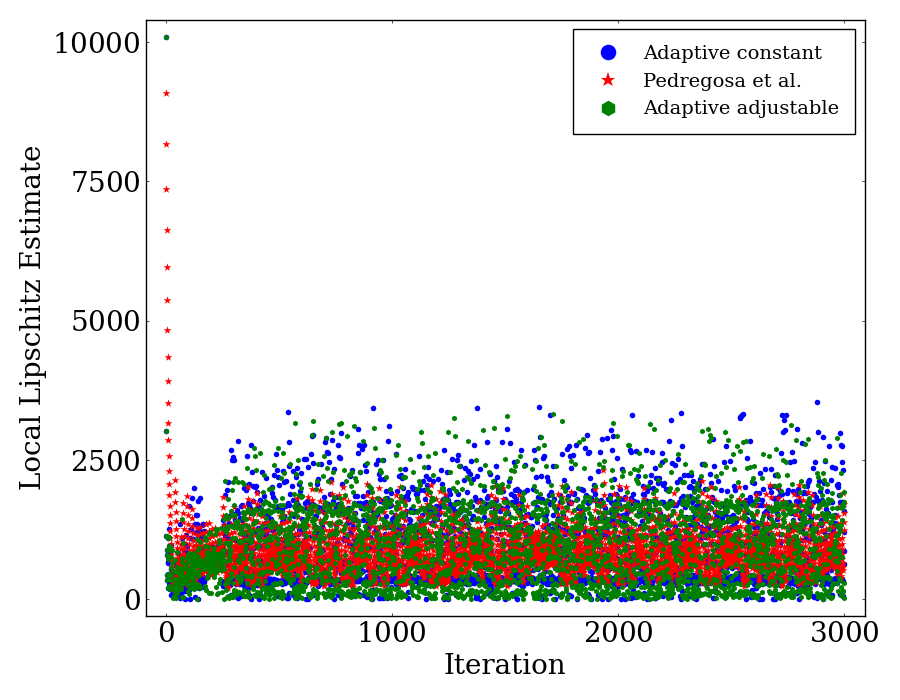

Saved plot: /content/output/ROS_Gap.eps


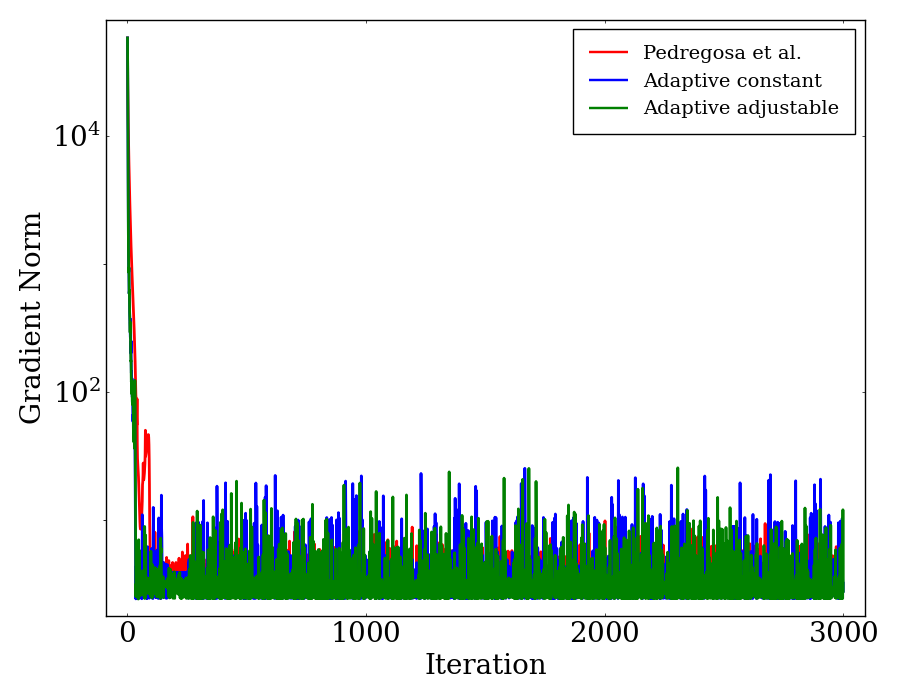

Saved plot: /content/output/ROS_Gap_vs_time.eps


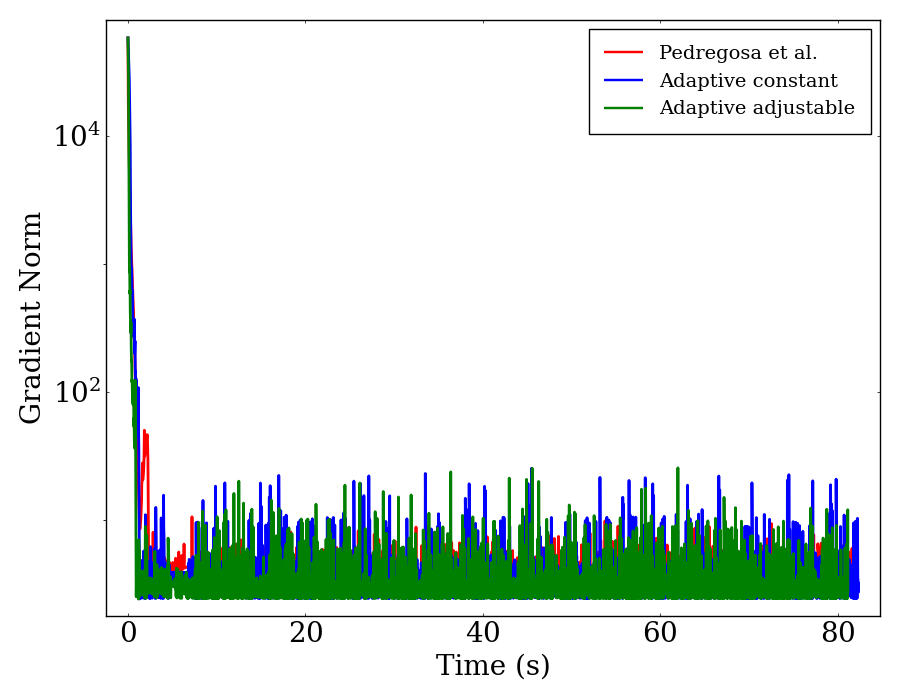

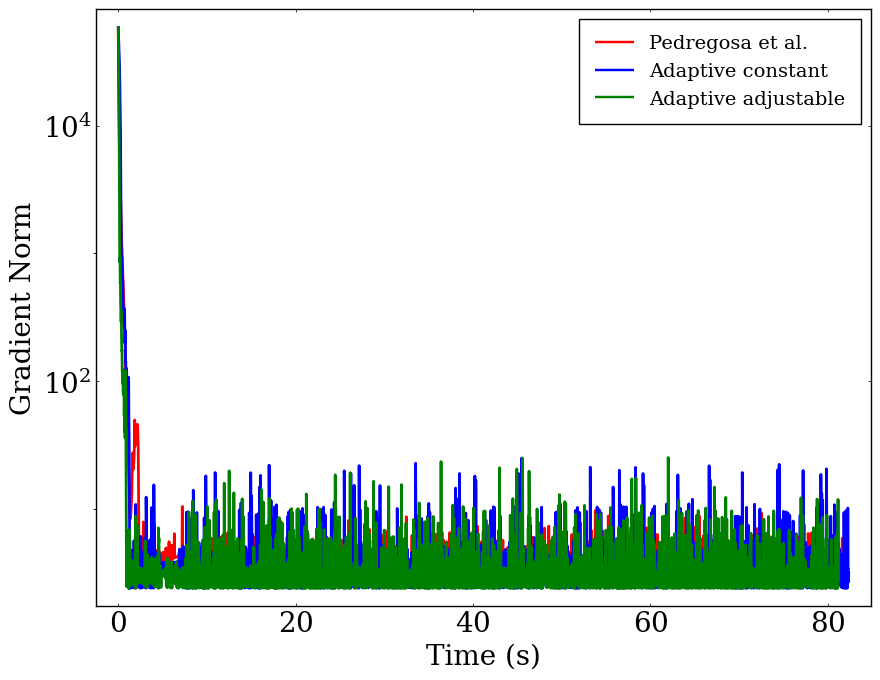

In [ ]:
# Ensure all necessary packages are loaded
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays



our = matread(joinpath(output_dir, "results_FW_OUR.mat"))
our5 = matread(joinpath(output_dir, "results_FW_OUR_5.mat"))
ped = matread(joinpath(output_dir, "results_FW_Pedregosa.mat"))

#______________________________________________________________________________#
# Define the output file for the table
println("\n# Summary of Results:")
println("Method             | Iterations | Time     | Objective | Dual Gap   | Backtracking | Max L_k   | Mean L_k")
println("-------------------|------------|----------|-----------|------------|--------------|-----------|----------|")
println("Adaptive constant  | $(length(our["values"]) - 1) | $(round(sum(our["times"]), digits=4)) | $(round(our["values"][end], digits=6)) | $(round(our["gaps"][end], digits=4)) | $(sum(our["backtrack_counts"])) | $(round(maximum(our["L_ks"]), digits=6)) | $(round(mean(our["L_ks"]), digits=6))")
println("Adaptive adjustable| $(length(our5["values"]) - 1) | $(round(sum(our5["times"]), digits=4)) | $(round(our5["values"][end], digits=6)) | $(round(our5["gaps"][end], digits=4)) |  $(sum(our5["backtrack_counts"])) | $(round(maximum(our5["L_ks"]), digits=6)) | $(round(mean(our5["L_ks"]), digits=6))")
println("Pedregosa et al.   | $(length(ped["values"]) - 1) | $(round(sum(ped["times"]), digits=4)) | $(round(ped["values"][end], digits=6)) | $(round(ped["gaps"][end], digits=4)) | $(sum(ped["backtrack_counts"])) | $(round(maximum(ped["L_ks"]), digits=6)) | $(round(mean(ped["L_ks"]), digits=6))")
println("\nAll computations and plotting complete. Check $output_dir for results.")
#______________________________________________________________________________#
# Print confirmation to console
println("All computations and plotting complete. Check $output_dir for results.")


#________________________new________Ploting_______________________________________#
function create_and_save_plots()
    # Load data
    our = matread(joinpath(output_dir, "results_FW_OUR.mat"))
    our5 = matread(joinpath(output_dir, "results_FW_OUR_5.mat"))
    ped = matread(joinpath(output_dir, "results_FW_Pedregosa.mat"))


    # Compute cumulative times
    our_cum_times = [0.0; cumsum(our["times"][2:end])]
    our5_cum_times = [0.0; cumsum(our5["times"][2:end])]
    ped_cum_times = [0.0; cumsum(ped["times"][2:end])]


    # Define style dictionary based on the template
    style = Dict(:titlefont => (20, "DejaVu Serif"),
                 :guidefont => (20, "DejaVu Serif"),
                 :tickfont => (20, "DejaVu Serif"),
                 :legendfont => (14, "DejaVu Serif"),
                 :grid => false,
                 :framestyle => :box,
                 :margin => 5mm,
                 #:size => (600, 400),
                 :size => (900, 700),
                 :linewidth => 2)

    # Lipschitz Constants (p1) - Unchanged
    p1 = Plots.plot(our["L_ks"],
                    label="Adaptive constant",
                    color=:blue,
                    seriestype=:scatter,
                    markersize=4,
                    marker=:circle,
                    markerstrokewidth=0,
                    xlabel="Iteration",
                    ylabel="Local Lipschitz Estimate",
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)

    Plots.plot!(p1, ped["L_ks"],
                    label="Pedregosa et al.",
                    color=:red,
                    seriestype=:scatter,
                    markersize=6,
                    marker=:star5,
                    markerstrokewidth=0)

    Plots.plot!(p1, our5["L_ks"],
                    label="Adaptive adjustable",
                    color=:green,
                    seriestype=:scatter,
                    markersize=4,
                    marker=:hexagon,
                    markerstrokewidth=0)

    Plots.savefig(p1, joinpath(output_dir, "ROS_L.eps"))
    println("Saved plot: ", joinpath(output_dir, "ROS_L.eps"))
    display(p1)

    # Dual Gap vs Iteration (p2)
    p2 = Plots.plot(ped["gaps"],
                    label="Pedregosa et al.",
                    color=:red,
                  #  linestyle=:dot,
                    markerstrokecolor=:red,
                    markersize=5,
                    yscale=:log10,
                    xlabel="Iteration",
                    ylabel="Gradient Norm",
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)

    Plots.plot!(p2, our["gaps"],
                    label="Adaptive constant",
                    color=:blue,
                  #  linestyle=:solid,
                    markerstrokecolor=:blue,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p2, our5["gaps"],
                    label="Adaptive adjustable",
                    color=:green,
                  #  linestyle=:dash,
                    markerstrokecolor=:green,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.savefig(p2, joinpath(output_dir, "ROS_Gap.eps"))
    println("Saved plot: ", joinpath(output_dir, "ROS_Gap.eps"))
    display(p2)


    # Dual Gap vs Time plot (p6)
    p6 = Plots.plot(ped_cum_times[1:end-1],
                    ped["gaps"][1:end],
                    label="Pedregosa et al.",
                    color=:red,
                   # linestyle=:dot,
                    markerstrokecolor=:red,
                    yscale=:log10,
                    xlabel="Time (s)",
                    ylabel="Gradient Norm",
                    markersize=5,
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)


    Plots.plot!(p6, our_cum_times[1:end-1],
                    our["gaps"][1:end],
                    label="Adaptive constant",
                    color=:blue,
                  #  linestyle=:solid,
                    markerstrokecolor=:blue,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p6, our5_cum_times[1:end-1],
                    our5["gaps"][1:end],
                    label="Adaptive adjustable",
                    color=:green,
                   # linestyle=:dash,
                    markerstrokecolor=:green,
                    markersize=5,
                    linewidth=style[:linewidth])


    Plots.savefig(p6, joinpath(output_dir, "ROS_Gap_vs_time.eps"))
    println("Saved plot: ", joinpath(output_dir, "ROS_Gap_vs_time.eps"))
    display(p6)




end

create_and_save_plots()
#______________________________________________________________________________#

In [ ]:
# Step 1: Zip the correct output folder
try
    run(`zip -r /content/output.zip /content/output`)
    println("Zipping successful!")
catch e
    println("Error during zipping: ", e)
end

# Step 2: Prepare to download the file
using PyCall

# Import the Python module *before* the try...catch block
@pyimport google.colab.files as colab_files

# Step 3: Trigger the download
try
    println("Preparing to download...")
    println("Please check your browser to confirm the download.")
    # Download the correctly named zip file
    colab_files.download("/content/output.zip")
catch e
    println("Error during download: ", e)
    println("Please ensure you are running this in a Google Colab environment.")
end

  adding: content/output/ (stored 0%)
  adding: content/output/results_FW_OUR.mat (deflated 37%)
  adding: content/output/ROS_L.eps (deflated 62%)
  adding: content/output/ROS_L2.eps (deflated 62%)
  adding: content/output/ROS_Gap.eps (deflated 58%)
  adding: content/output/results_FW_OUR_5.mat (deflated 37%)
  adding: content/output/results_FW_Pedregosa.mat (deflated 37%)
  adding: content/output/ROS_Gap_vs_time.eps (deflated 58%)
Zipping successful!


LoadError: ArgumentError: Package PyCall not found in current path.
- Run `import Pkg; Pkg.add("PyCall")` to install the PyCall package.